Nama : Harfely Leipary<br>
NIM : 632024001<br>
MataKuliah : _DeepLearning and Machine Learning_

<p><li><i><a>https://www.kaggle.com/code/kushagra3204/sentiment-emotion-analysis/input</a></i></li></p>

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import  Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, SimpleRNN, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [4]:
import warnings
warnings.filterwarnings('ignore')

Membaca DataSet

In [6]:
data = pd.read_csv('combined_emotion.csv')

In [12]:
print (data.shape)
print (data.columns)

(422746, 2)
Index(['sentence', 'emotion'], dtype='object')


In [13]:
data.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [15]:
data.sample(10)

,sentence,emotion
193060,i woke up body extremely heavy feeling oh so r...,fear
243380,i feel like i did well this week,joy
260286,i feel scared because this is a very expensive...,fear
19373,i go to cecil mcbee i feel glad so i become to...,joy
56010,i feel good i feel good a href http ifeelgood,joy
90462,i have no where to be or be somewhere where i ...,sad
2814,im feeling very depressed,sad
356048,ive found that setting things up here even a v...,joy
415837,i feel gloomy a class post count link href htt...,sad
263212,i apply it after i wash my face at night it do...,love


In [16]:
data

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
422741,i begun to feel distressed for you,fear
422742,i left feeling annoyed and angry thinking that...,anger
422743,i were to ever get married i d have everything...,joy
422744,i feel reluctant in applying there because i w...,fear


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [20]:
data.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [22]:
data.describe()

,sentence,emotion
count,422746,422746
unique,393822,6
top,i feel more adventurous willing to take risks ...,joy
freq,16,143067


In [24]:
data.drop_duplicates(inplace=True)
data.sample()

,sentence,emotion
755,ive broken them in and they feel lovely until ...,love


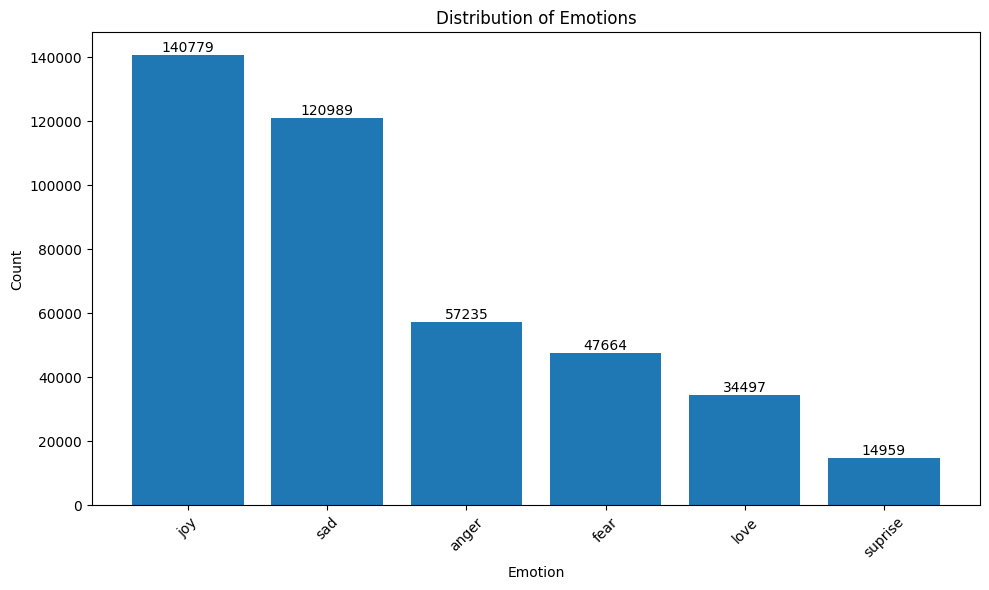


Total number of emotion classes: 6


In [ ]:
# mengambil emotion counts
emotion_counts = data['emotion'].value_counts()

# membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

# menambahkan value labels on top of each bar
for i, v in enumerate(emotion_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print total number of classes
print(f"\nTotal number of emotion classes: {len(emotion_counts)}")

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=data['emotion'].unique(),
    y=data['emotion']
)

# Membuat dictionary mapping classes untuk weights
class_weight_dict = dict(zip(data['emotion'].unique(), class_weights))

print("\nClass weights:")
for emotion, weight in class_weight_dict.items():
    print(f"{emotion}: {weight:.4f}")


Class weights:
fear: 1.4551
sad: 0.5732
love: 2.0104
joy: 0.4926
suprise: 4.6363
anger: 1.2117


In [27]:
classes = data['emotion'].unique()
classes

array(['fear', 'sad', 'love', 'joy', 'suprise', 'anger'], dtype=object)

Embedings

In [ ]:
# mengambil unique words (actual vocabulary size)
unique_words = set(' '.join(data['sentence']).lower().split())
vocab_size = len(unique_words)
print(f"Actual vocabulary size (unique words): {vocab_size}")

# Total words (including repetitions)
total_words = len(' '.join(data['sentence']).split())
print(f"Total number of words in the data: {total_words}")

Actual vocabulary size (unique words): 75302
Total number of words in the data: 8000075


Spliting the data

In [29]:
X = data['sentence']
y = data['emotion']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 332898
Test set size: 83225


In [ ]:
num_words = 50000
embedding_dim = 100
max_length = 100

# fungsi untuk mengambil maximum length of the data text for padding
max_length = min(max([len(x.split()) for x in X]), max_length)
print(f"Maximum length of the data text: {max_length}")

Maximum length of the data text: 100


In [ ]:
#membuat tokenizer-nya
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

#Mengambil vocabulary size from tokenizer
vocab_size =  min(len(tokenizer.word_index) + 1, num_words)    # +1 for padding token (0)
print(f"Tokenizer vocabulary size: {vocab_size}")

Tokenizer vocabulary size: 50000


In [33]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_onehot = to_categorical(y_encoded)

# Split into train/test
_, _, y_train, y_test = train_test_split(
    X, y_onehot,
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [34]:
y_train, y_test

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]]))

In [35]:
# see how many words are in the tokenizer
print(f"Number of words in the tokenizer: {len(tokenizer.word_index)}")

print(f"Tokenizer vocabulary size: {len(tokenizer.word_index) + 1}")  # +1 for padding token

Number of words in the tokenizer: 67803
Tokenizer vocabulary size: 67804


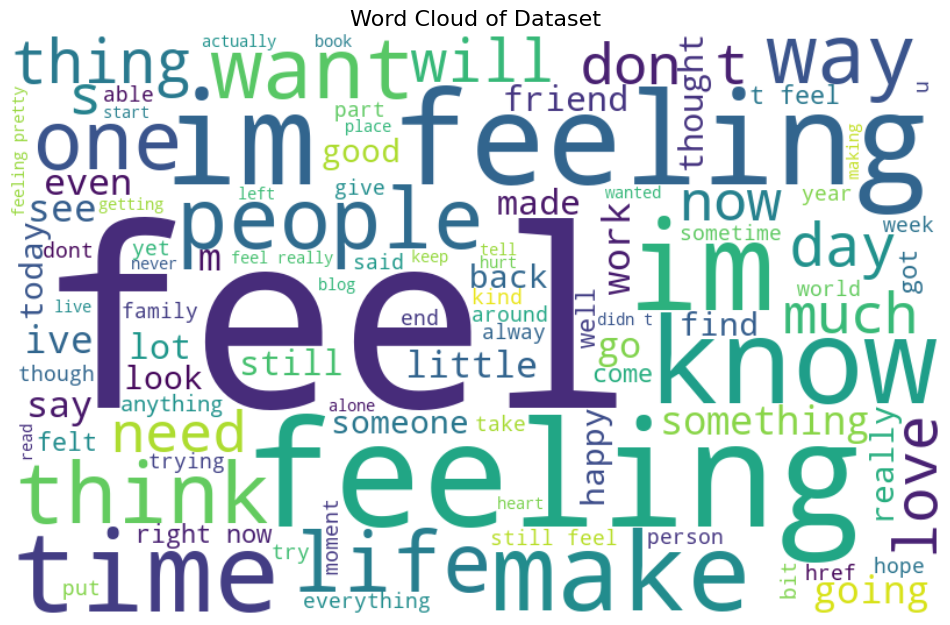

In [58]:
from wordcloud import WordCloud

# Gabungkan semua teks dalam X_train
all_words = ' '.join(X)
all_words = all_words.lower()  # Biar huruf kecil semua

# Buat Word Cloud
wordcloud = WordCloud(width=800, height=500, background_color='white', max_words=100).generate(all_words)

# Plot Word Cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hilangkan garis sumbu
plt.title('Word Cloud of Dataset', fontsize=16)
plt.show()


In [36]:
X_train, y_train

(array([[   1,    2,   13, ...,    0,    0,    0],
        [   1,  198,    7, ...,    0,    0,    0],
        [   1,  102,    4, ...,    0,    0,    0],
        ...,
        [   1,  118,    2, ...,    0,    0,    0],
        [   1,  144,  244, ...,    0,    0,    0],
        [  16,    7, 1230, ...,    0,    0,    0]], dtype=int32),
 array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]))

In [37]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape) 
print("y_test shape:", y_test.shape)

X_train shape: (332898, 100)
X_test shape: (83225, 100)
y_train shape: (332898, 6)
y_test shape: (83225, 6)


In [38]:
# Print 5 sample sentences with their details
print("Sample sentences with details:\n")
for i in range(5):
    # Get original text
    sentence = X[i]
    # Get encoded sequence
    encoded_seq = X_train[i]
    # Get emotion label (from one-hot to label)
    emotion_idx = np.argmax(y_train[i])
    emotion = label_encoder.inverse_transform([emotion_idx])[0]
    
    print(f"Sample {i+1}:")
    print(f"Text: {sentence}")
    print(f"Encoded sequence: {encoded_seq[:10]}...")  # Show first 10 tokens
    print(f"Emotion: {emotion}")
    print(f"One-hot encoded emotion: {y_train[i]}")
    print("-" * 80)

Sample sentences with details:

Sample 1:
Text: i just feel really helpless and heavy hearted
Encoded sequence: [  1   2  13   1  85  60 673  15  50   1]...
Emotion: sad
One-hot encoded emotion: [0. 0. 0. 0. 1. 0.]
--------------------------------------------------------------------------------
Sample 2:
Text: ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
Encoded sequence: [   1  198    7   46   46  635   44    5 1670    0]...
Emotion: sad
One-hot encoded emotion: [0. 0. 0. 0. 1. 0.]
--------------------------------------------------------------------------------
Sample 3:
Text: i gave up my internship with the dmrg and am feeling distraught
Encoded sequence: [  1 102   4   2  50 848   7   3  66  50]...
Emotion: sad
One-hot encoded emotion: [0. 0. 0. 0. 1. 0.]
----------------------------------------

In [ ]:
# Contoh tokens and embeddings-NYA
print("Contoh tokens and their embeddings:\n")
for word in list(tokenizer.word_index.keys())[:2]:
    word_id = tokenizer.word_index[word]

    print(f"Token: {word}")
    print(f"Index in vocabulary: {word_id}")
    print("-" * 80)

Sample tokens and their embeddings:

Token: i
Index in vocabulary: 1
--------------------------------------------------------------------------------
Token: feel
Index in vocabulary: 2
--------------------------------------------------------------------------------


Model

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
checkpoint = lambda name: ModelCheckpoint(name, monitor='val_accuracy', save_best_only=True, mode='max')

In [41]:
# Model hyperparameters
NUM_EMOTION_CLASSES = 6
VALIDATION_SPLIT = 0.2
DROPOUT_RATE = 0.2
VERBOSE = 0

GRU

In [42]:
# Input layer for sequences
input = Input(shape=(max_length,))

# Embedding layer
x = Embedding(input_dim=vocab_size,
              output_dim=embedding_dim, input_length=max_length)(input)

# GRU layer
x = GRU(128, return_sequences=True)(x)
x = BatchNormalization()(x)

# Dropout for regularization
x = Dropout(0.3)(x)

# GRU layer
x = GRU(128, return_sequences=False)(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(NUM_EMOTION_CLASSES, activation='softmax')(x)

# Create model
gru_model = Model(inputs=input, outputs=x)

# Compile model
gru_model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 128)       │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,197,062 (19.83 MB)

 Trainable params: 5,196,550 (19.82 MB)

 Non-trainable params: 512 (2.00 KB)

In [63]:
# Train the model
history = gru_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=5,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[early_stopping, reduce_lr, checkpoint('best_model_gru_1_5M.keras')]
)

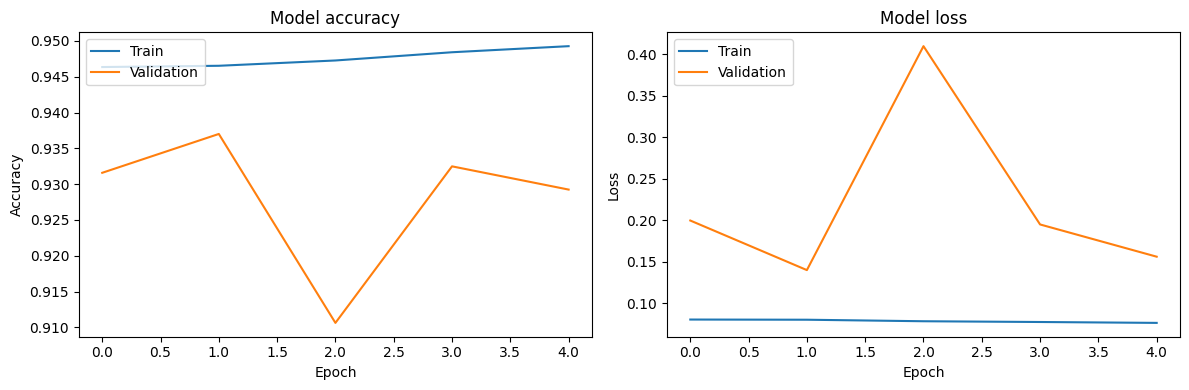

In [64]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step

Accuracy: 0.9358


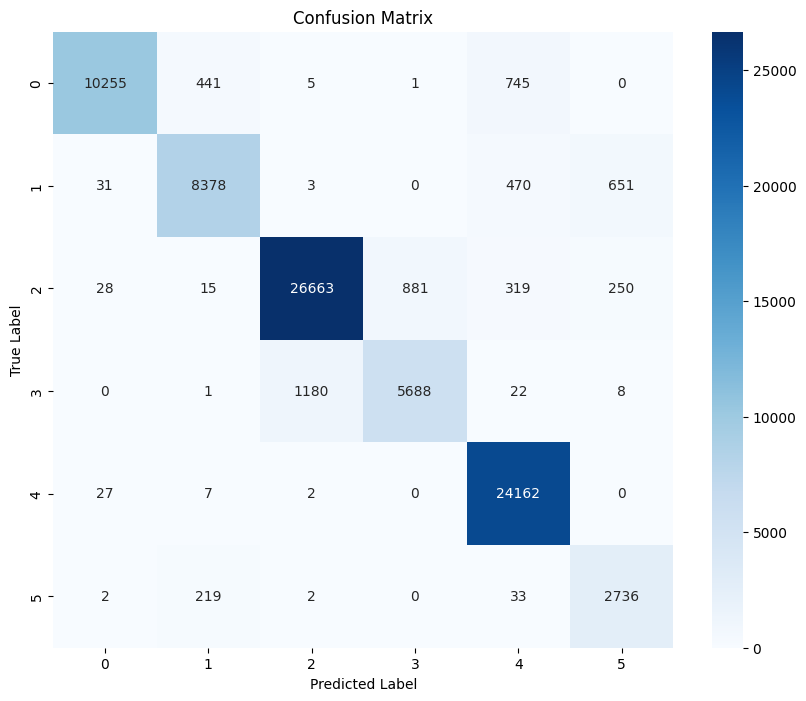


Classification Report:

              precision    recall  f1-score   support

        fear       0.99      0.90      0.94     11447
         sad       0.92      0.88      0.90      9533
        love       0.96      0.95      0.95     28156
         joy       0.87      0.82      0.84      6899
     suprise       0.94      1.00      0.97     24198
       anger       0.75      0.91      0.82      2992

    accuracy                           0.94     83225
   macro avg       0.90      0.91      0.91     83225
weighted avg       0.94      0.94      0.94     83225



In [54]:
# Get predictions on validation set
y_pred = gru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and print accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
target_names = ['fear', 'sad', 'love', 'joy', 'suprise', 'anger'] # Based on the emotion labels seen in context
print('\nClassification Report:\n')
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))